<a href="https://colab.research.google.com/github/Avassophia/Credit-Card-Fraud-Detection/blob/main/Detecting_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression To Predict Credit Card Fraud
In this project, we will implement logistic regression from scratch - Model 1 - to predict whether certain credit card transactions are fradulent.
We then compare our model to scikit-learn's logistic regression model - Model 2.

In [68]:
#import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#load dataset
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/creditcard.csv'
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Visualize DataFrame:

In [65]:
print(df)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

## Imbalanced Dataset
This dataset is **highly imabalanced**. There are 284315 non-fradulent transactions, compared to only 492 fradulent transactions.
Ultimately, the dataset is comprised of 99.83% non-fradulent transcations and only 0.17% fradulent transactions.


In [79]:
counts = df['Class'].value_counts()
print(counts)
print(f"{round((counts[0]/(counts[0]+counts[1]))*100,2)}% non-fraudulent transcations")
print(f"{round((counts[1]/(counts[0]+counts[1]))*100,2)}% fraudulent transcations")

Class
0    284315
1       492
Name: count, dtype: int64
99.83% non-fraudulent transcations
0.17% fraudulent transcations


In [69]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Model Assumption
As we can see from the DataFrame, there are many indepdent features ($V1,V2...V28, and Amount$). While we could represent our model as a linear combination of all of these features - $\sigma(w1x1+w2x2+...w29x29+b)$, this makes our model quite complex. Further, not all of our features may be equally important in helping predict the target. For our scratch-model demo, we will assume that credit card fraud can be predicted as a linear combination of *three features*, so our model = $\sigma(w1x1+w2x2+w3x3+b)$.

#Selecting Our Features
How do we discover the three most informative features? An informative feature is defined as a feature that provides a **useful predictive signal** on whether a transaction is fradulent.
##Naive Approach
A simple way could be to visualize the correlations between each feature and the target, and select the three features with the highest correlation coefficient. However, this strategy has three significant downfalls.


*   Correlation does not capture nonlinear relationships.
*   Correlation does not capture multivariate effects.
*   Correlation is highly sensitive to outliers.

##Improved Approach
Instead, we will calculate the mutual information between each feature and the target. Mutual information describes how much information a feautre provides about the target. Unlike correlation, Mutual information captures nonlinear and multivariate relationships.
Mutual Information between two variables \(X\) and \(Y\) is defined as:
$$
I(X; Y) = \sum_{x \in X} \sum_{y \in Y} P(x, y) \, \log \left( \frac{P(x, y)}{P(x) \, P(y)} \right)
$$, where $I(X; Y) = 0$ if $X$ and $Y$ are independent, and a larger $I(X; Y)$ means the variables share more information (are more dependent).

To compute Mutual Information efficiently, we will use the mutual_info_classif from scikit-learn.






In [7]:
# remove target column to create an X DataFrame
X=df.drop(columns="Class")

#create target DataFrame
y=df["Class"]

from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X, y)

print(mi)


[0.00190959 0.00212666 0.00322805 0.00495192 0.00497593 0.00238894
 0.0023878  0.00395065 0.00189842 0.00427669 0.00753036 0.0068312
 0.00760123 0.00040847 0.00813614 0.00031483 0.0061444  0.00825807
 0.00431693 0.00147245 0.00120666 0.00245218 0.00035318 0.00076152
 0.00064199 0.00049844 0.00049975 0.00244407 0.00187132 0.00150009]


In [8]:
# find the top three highest mutual information values
top3_idx = np.argsort(mi)[-3:][::-1]  # sort ascending, take last 3, reverse
print("Top 3 MI values:", mi[top3_idx])
print("Top 3 Feature Indicies:", top3_idx)


Top 3 MI values: [0.00825807 0.00813614 0.00760123]
Top 3 Feature Indicies: [17 14 12]


In [9]:
print(df[df.columns[17]])
print(df[df.columns[14]])
print(df[df.columns[12]])


0         0.207971
1        -0.114805
2         1.109969
3        -0.684093
4        -0.237033
            ...   
284802    1.991691
284803   -0.025693
284804    0.313502
284805    0.509928
284806   -0.660377
Name: V17, Length: 284807, dtype: float64
0        -0.311169
1        -0.143772
2        -0.165946
3        -0.287924
4        -1.119670
            ...   
284802    4.626942
284803   -0.675143
284804   -0.510602
284805    0.449624
284806   -0.084316
Name: V14, Length: 284807, dtype: float64
0        -0.617801
1         1.065235
2         0.066084
3         0.178228
4         0.538196
            ...   
284802    2.711941
284803    0.915802
284804    0.063119
284805   -0.962886
284806   -0.031513
Name: V12, Length: 284807, dtype: float64



The top three features with the highest mutual importance are V17,V14, and V12. These are the features we will use for our model.

In [10]:
import math
X_mod=df[["V17","V14","V12"]]
X_mod
def sigmoid(x):
  e=math.e
  return 1/(1+e**(-x))

##Splitting the Data
We use the help of Scikit learn to split our data into 80% training and 20% testing.

In [11]:
from sklearn.model_selection import train_test_split

# X_mod = your features
# y = your target/labels

X_train, X_test, y_train, y_test = train_test_split(
    X_mod, y, test_size=0.2, random_state=42
)
X_train

,V17,V14,V12
223361,-0.930844,-0.253266,1.691496
165061,-1.630444,-1.193347,-0.726597
238186,0.044374,-0.640249,-0.072768
150562,-0.613260,1.271254,-4.179628
138452,0.007803,0.187685,1.595929
...,...,...,...
119879,-0.356782,0.600937,0.777009
259178,-0.462528,0.384625,0.346437
131932,-0.539887,-0.019493,0.022804
146867,-0.396148,0.927786,0.570400


In [15]:
rows=len(X_train)
#rows=200
weights=np.zeros(len(X_train.columns)+1) #last weight represents b, the bias term
a=0.1 #a=alpha, the learning rate
epochs=2000
y_arr=y_train.to_numpy()
X_bias = np.hstack([X_train.to_numpy(), np.ones((rows, 1))])
losses=[]
for epoch in range(epochs):

  yhats=sigmoid(X_bias @ weights)

  bce = -np.mean(y_arr * np.log(yhats) + (1 - y_arr) * np.log(1 - yhats))



  grads=np.zeros(len(weights))
  errors=yhats-y_arr
  grads[:-1]=(errors@X_train)/rows
  grads[-1]=np.mean(errors)

  weights=weights-a*grads
  if epoch%100==0:
    losses.append(bce)
    print(f"Epoch: {epoch}, loss:{bce:.3f}")

print(f"Final weights: {[round(w,3) for w in weights]}")


Epoch: 0, loss:0.693
Epoch: 100, loss:0.110
Epoch: 200, loss:0.057
Epoch: 300, loss:0.039
Epoch: 400, loss:0.030
Epoch: 500, loss:0.024
Epoch: 600, loss:0.021
Epoch: 700, loss:0.018
Epoch: 800, loss:0.017
Epoch: 900, loss:0.015
Epoch: 1000, loss:0.014
Epoch: 1100, loss:0.013
Epoch: 1200, loss:0.012
Epoch: 1300, loss:0.012
Epoch: 1400, loss:0.011
Epoch: 1500, loss:0.010
Epoch: 1600, loss:0.010
Epoch: 1700, loss:0.010
Epoch: 1800, loss:0.009
Epoch: 1900, loss:0.009
Final weights: [np.float64(-0.213), np.float64(-0.376), np.float64(-0.25), np.float64(-5.228)]


Our final weights are [-0.213,-0.376,-0.25,-5.228]. So, our logisitic regression equation = $$\frac{1}{1 + e^{-(0.213x_{1} + 0.376x_{2} + 0.25x_{3} + 5.228)}}$$

Now that we have our final weights, we have to compute for each row in our testset the model's prediction. We do so by taking the dot product of our final weights with each row's feature values, and then activating this value with the sigmoid function. If the number returned is greater or equal to some threshold t, we predict class 1. Otherwise, we will predict class 0. The threshold for logistic regression is usually 0.5, but we will select a lower threshold of 0.15.

Selecting a lower threshold prioritizes getting a higher recall score, which is important in the case of credit card fraud. There are limited positives (fraudulent transactions) in our dataset, but it is essential that we classify these rare cases correctly. Recall measures how many true positives were classified correctly, thus this metric is a high priority.

In [55]:
y_pred=[]
X_bias = np.hstack([X_test.to_numpy(), np.ones((len(X_test), 1))])
for i in range(len(X_bias)):
  z=X_bias[i]@ weights
  if sigmoid(z)>=0.15:
    y_pred.append(1)
  else:
    y_pred.append(0)
print("Model predictions")
print(y_pred)
len(y_pred)





Model predictions
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

56962

## Visualize Loss Curve for Model 1

We will see how the loss decreases over iterations through the loss curve below. After 100 epochs, the loss steeply declines, indicating our model is learning from the data.

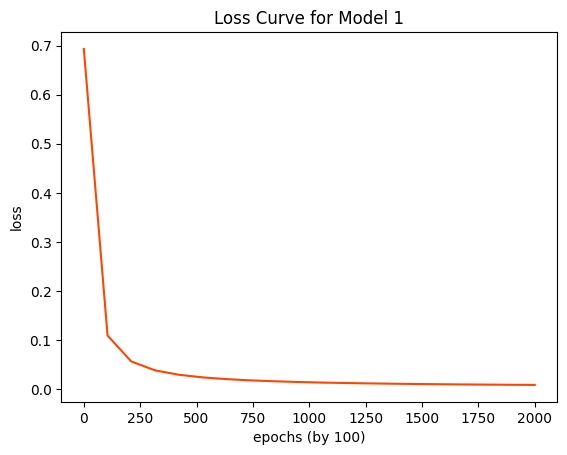

In [27]:
plt.plot(np.linspace(0,2000,20),losses,c="orangered")
plt.xlabel("epochs (by 100)")
plt.ylabel("loss")
plt.title("Loss Curve for Model 1")
plt.show()


# Use Model's Weights to make predictions
Above, we ran logistic regression to determine the model's final weights.
Now, we use the equation to make a prediction (fradulent or not) for each entry.


##Evaluating Performance
First, we will visualize true positives, true negatives, false positives, and false negatives on a confusion matrix. Then, to evaluate performance, we will use three metrics- accuracy, precision, and recall.

**1. Accuracy**  
Accuracy measures how many of our predictions are correct.
- Formula:  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  

**2. Precision**  
Precision measures, out of items classified as positive, how many are true positives?
- Formula:  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$  

**3. Recall (Sensitivity)**  
Recall measures, out of all true positives, how many were correctly classified as positive?
- Formula:  
$$
\text{Recall} = \frac{TP}{TP + FN}
$$  







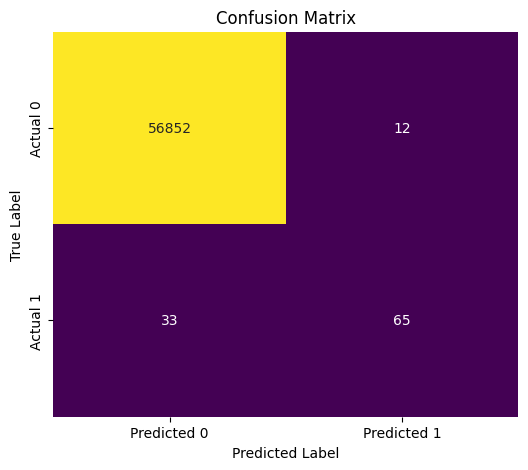

Model 1's accuracy: 0.999
Model 1's precision: 0.844
Model 1's recall: 0.663


In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#function to get all 3 metrics
def metrics(y_test,y_pred):
  #convert DataFrame to array
  y_test=y_test.to_numpy()
  true_pos=0
  true_neg=0
  false_pos=0
  false_neg=0
  for i in range(len(y_test)):
    if y_pred[i]==1 and y_test[i]==1:
      true_pos+=1
    elif y_pred[i]==0 and y_test[i]==1:
      false_neg+=1
    elif y_pred[i]==1 and y_test[i]==0:
      false_pos+=1
    else:
      true_neg+=1
  acc=(true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
  prec=true_pos/(true_pos+false_pos)
  rec=true_pos/(true_pos+false_neg)
  return round(acc,3),round(prec,3),round(rec,3)

acc,prec,rec = metrics(y_test,y_pred)
print( f"Model 1's accuracy: {acc}")
print( f"Model 1's precision: {prec}")
print( f"Model 1's recall: {rec}")


#Comparing model to scikit-learn
Now that we have implemented logistic regression from scratch, we will compare it to scikit-learn's version. Scikit-learn uses all features in its implementation. Does using all features improve the model's predictions? We will once more compute accuracy, precision, and recall to answer this.

Below, we implement logistic regression through scikit-learn.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

#Implement logistic regression
log_reg = LogisticRegression(max_iter=1000)  # increase max_iter if it doesn't converge
log_reg.fit(X_train, y_train)

# Test set predictions
y_pred = log_reg.predict(X_test)

# Evaluate metrics
print(f"Model 2's Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Model 2's Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Model 2's Recall:, {recall_score(y_test, y_pred):.3f}")


Model 2's Accuracy: 0.999
Model 2's Precision: 0.844
Model 2's Recall:, 0.551


## Comparing metrics of Models 1 and 2
Both models have an accuracy of 0.999, and a precision of 0.844
 Model 1's recall (0.633) is slightly higher than Model 2's recall (0.551).

Intrestingly, in terms of recall, our model from scratch outperformed Scikit-learn's model. A reason for this could be because Scikit-learn uses a standard threshold of 0.5, which is rarely optimal for a highly imbalanced dataset.
Another reason could be because Scikit-learn uses all 28 features, and hence could overfit the training data.

## Conclusion

In this project, we implemented a **custom logistic regression model** using a subset of features from the credit card fraud dataset. We compared its performance to **Scikit-learn’s logistic regression** using all features.  

- Despite using fewer features, the custom model achieved **comparable  precision and recall** on the test set, demonstrating that careful feature selection can improve detection of rare fraudulent transactions.  
- This highlights the importance of **feature selection and threshold tuning** for imbalanced datasets.
- Overall, this project shows that even a simple model with a small number of well-chosen features can be highly effective and interpretable.  

### Next Steps
- Incorporate advanced sampling techniques (e.g., SMOTE) to better handle imbalanced data.  
- Explore additional machine learning algorithms, such as Random Forest or XGBoost, to compare performance.  
